# Optical Flow

Optical flow tracks objects by looking at where the *same* points have moved from one image frame to the next. Let's load in a few example frames of a pacman-like face moving to the right and down and see how optical flow finds **motion vectors** that describe the motion of the face!

As usual, let's first import our resources and read in the images.

In [1]:
import numpy as np
import matplotlib.image as mpimg  # for reading in images
import matplotlib.pyplot as plt
import cv2  # computer vision library
%matplotlib inline

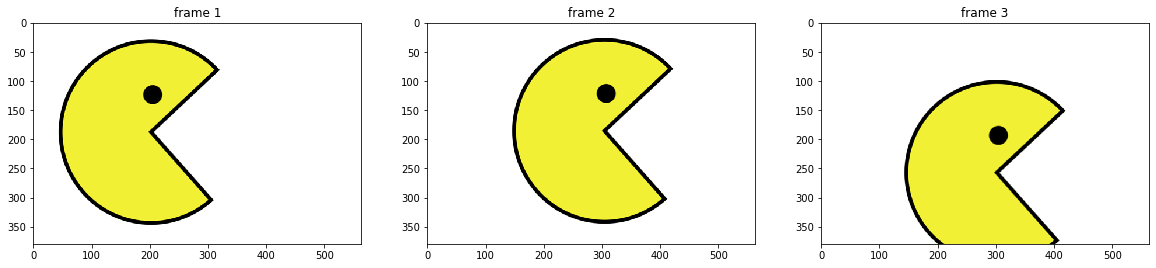

In [2]:

# Read in the image frames
frame_1 = cv2.imread('images/pacman_1.png')
frame_2 = cv2.imread('images/pacman_2.png')
frame_3 = cv2.imread('images/pacman_3.png')

# convert to RGB
frame_1 = cv2.cvtColor(frame_1, cv2.COLOR_BGR2RGB)
frame_2 = cv2.cvtColor(frame_2, cv2.COLOR_BGR2RGB)
frame_3 = cv2.cvtColor(frame_3, cv2.COLOR_BGR2RGB)


# Visualize the individual color channels
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.set_title('frame 1')
ax1.imshow(frame_1)
ax2.set_title('frame 2')
ax2.imshow(frame_2)
ax3.set_title('frame 3')
ax3.imshow(frame_3)


## Finding Points to Track

Befor optical flow can work, we have to give it a set of *keypoints* to track between two image frames!

In the below example, we use a **Shi-Tomasi corner detector**, which uses the same process as a Harris corner detector to find patterns of intensity that make up a "corner" in an image, only it adds an additional parameter that helps select the most prominent corners. You can read more about this detection algorithm in [the documentation](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_shi_tomasi/py_shi_tomasi.html). 

Alternatively, you could choose to use Harris or even ORB to find feature points. I just found that this works well.

**You sould see that the detected points appear at the corners of the face.**

[[[318.  82.]]

 [[308. 304.]]

 [[208. 188.]]

 [[309.  81.]]

 [[299. 304.]]

 [[199. 188.]]]


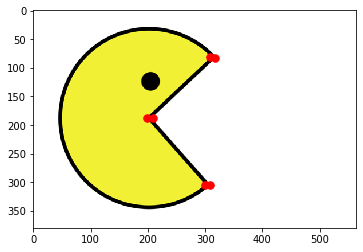

In [3]:
# parameters for ShiTomasi corner detection
feature_params = dict( maxCorners = 10,
                       qualityLevel = 0.2,
                       minDistance = 5,
                       blockSize = 5 )


# convert all frames to grayscale
gray_1 = cv2.cvtColor(frame_1, cv2.COLOR_RGB2GRAY)
gray_2 = cv2.cvtColor(frame_2, cv2.COLOR_RGB2GRAY)
gray_3 = cv2.cvtColor(frame_3, cv2.COLOR_RGB2GRAY)


# Take first frame and find corner points in it
pts_1 = cv2.goodFeaturesToTrack(gray_1, mask = None, **feature_params)

# display the detected points
plt.imshow(frame_1)
for p in pts_1:
    # plot x and y detected points
    plt.plot(p[0][0], p[0][1], 'r.', markersize=15)

# print out the x-y locations of the detected points
print(pts_1)

## Perform Optical Flow

Once we've detected keypoints on our initial image of interest, we can calculate the optical flow between this image frame (frame 1) and the next frame (frame 2), using OpenCV's `calcOpticalFlowPyrLK` which is [documented, here](https://docs.opencv.org/trunk/dc/d6b/group__video__track.html#ga473e4b886d0bcc6b65831eb88ed93323). It takes in an initial image frame, the next image, and the first set of points, and it returns the detected points in the next frame and a value that indicates how good matches are between points from one frame to the next.

The parameters also include a window size and maxLevels that indicate the size of a window and mnumber of levels that will be used to scale the given images using pyramid scaling; this version peforms an iterative search for matching points and this matching criteria is reflected in the last parameter (you may need to change these values if you are working with a different image, but these should work for the provided example).

In [4]:
# parameters for lucas kanade optical flow
lk_params = dict( winSize  = (5,5),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))


# calculate optical flow between first and second frame
pts_2, match, err = cv2.calcOpticalFlowPyrLK(gray_1, gray_2, pts_1, None, **lk_params)

# Select good matching points between the two image frames
good_new = pts_2[match==1]
good_old = pts_1[match==1]


Next, let's display the resulting motion vectors! You should see the first image with motion vectors drawn on it that indicate the direction of motion from the first frame to the next.

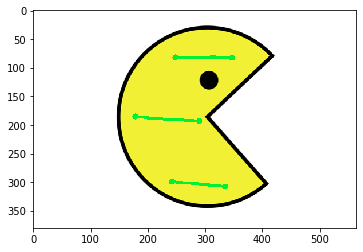

In [5]:
# create a mask image for drawing (u,v) vectors on top of the second frame
mask = np.zeros_like(frame_2)

# draw the lines between the matching points (these lines indicate motion vectors)
for i,(new,old) in enumerate(zip(good_new,good_old)):
    a,b = new.ravel()
    c,d = old.ravel()
    # draw points on the mask image
    mask = cv2.circle(mask,(a,b),5,(200),-1)
    # draw motion vector as lines on the mask image
    mask = cv2.line(mask, (a,b),(c,d), (200), 3)
    # add the line image and second frame together

composite_im = np.copy(frame_2)
composite_im[mask!=0] = [0]

plt.imshow(composite_im)